In [1]:
import os
import sys
import numpy as np
import stopit
import time
import matplotlib.pyplot as plt

In [2]:
# importing neurokit2 as a submodule so that it's always the same version
repo_name = "fixpeaks_with_large_gaps"
submodule_parent_dir = "lib"
submodule_name = "NeuroKit"

repo_path = os.getcwd()
base_dir = os.path.basename(repo_path)
while base_dir != repo_name:
    repo_path = os.path.dirname(os.path.abspath(repo_path))
    base_dir = os.path.basename(repo_path)
    
submodule_path = os.path.join(repo_path, submodule_parent_dir, submodule_name)
sys.path.insert(0, submodule_path)

In [3]:
import neurokit2 as nk

In [31]:
signal = nk.signal_simulate(duration=20, sampling_rate=1000, frequency=1)
peaks_true = nk.signal_findpeaks(signal)["Peaks"]
peaks = np.delete(peaks_true, [5,6,7,8,9,10,15,16,17])  # create gaps 
# (I added more than in the example in the function docstring)
peaks = np.sort(np.append(peaks, [1350, 11350, 18350]))  # add artifacts

In [32]:
peaks

array([  250,  1250,  1350,  2250,  3250,  4250, 11250, 11350, 12250,
       13250, 14250, 18250, 18350, 19250], dtype=int64)

In [33]:
peaks = np.array([250,  1250,  1350,  2250,  3250])
interval = nk.signal_period(peaks, sampling_rate=1000, desired_length=None)
interval

array([0.75, 1.  , 0.1 , 0.9 , 1.  ])

In [34]:
nk.standardize(interval)

array([ 0.        ,  0.66226618, -1.72189206,  0.39735971,  0.66226618])

In [35]:
relative_interval_max = 0.5
sampling_rate = 1
robust=False
import pandas as pd

In [36]:
interval = nk.signal_period(peaks, sampling_rate=sampling_rate, desired_length=None)
if relative_interval_max is not None:
    outliers = nk.standardize(interval, robust=robust) > relative_interval_max
else:
    outliers = interval > interval_max
outliers_loc = np.where(outliers)[0]

# interval returned by signal_period at index 0 is the mean of the intervals
# so it does not actually correspond to whether the first peak is an outlier
outliers_loc = outliers_loc[outliers_loc != 0]

if np.sum(outliers) == 0:
    print("no outliers")
peaks_to_correct = peaks.copy().astype(float)

interval_without_outliers = interval[np.invert(outliers)]
mean_interval = np.nanmean(interval_without_outliers)

# go through the outliers starting with the highest indices
# so that the indices of the other outliers are not moved when
# unknown intervas are inserted
for loc in np.flip(outliers_loc):
    # compute number of NaNs to insert based on the mean interval
    n_nan = round(interval[loc] / mean_interval)

    # Delete peak corresponding to large interval and replace by N NaNs
    peaks_to_correct[loc] = np.nan
    peaks_to_correct = np.insert(peaks_to_correct, loc, [np.nan] * (n_nan - 1))
# Interpolate values
interpolated_peaks = pd.Series(peaks_to_correct).interpolate(limit_area="inside").values
# If there are missing values remaining, remove
peaks = interpolated_peaks[np.invert(np.isnan(interpolated_peaks))].astype(peaks.dtype)

In [39]:
interval_without_outliers

array([750., 100., 900.])

In [40]:
interval

array([ 750., 1000.,  100.,  900., 1000.])

In [41]:
peaks

array([ 250,  616,  983, 1350, 2250])

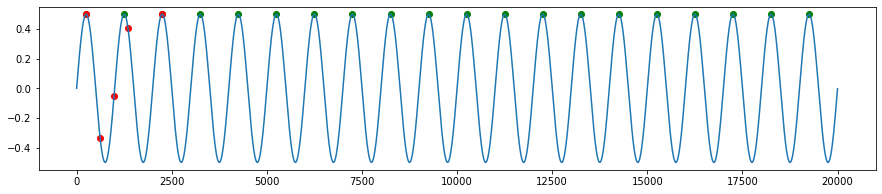

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.plot(signal)    
plt.scatter(peaks_true, signal[peaks_true], color="green")
plt.scatter(peaks, signal[peaks], color="red")

plt.show()

In [6]:
interval_maxes = [None, 1.5, 2.0]
max_seconds = 10
for interval_max in interval_maxes:
    print("Interval max: " + str(interval_max))
    with stopit.ThreadingTimeout(max_seconds) as context_manager:

        t0 = time.time()
        peaks_corrected = nk.signal_fixpeaks(peaks=peaks, interval_min=0.5, interval_max=interval_max, method="neurokit")
        t1 = time.time()

    if context_manager.state == context_manager.EXECUTED:
        total = t1-t0
        print("Took " + str(total) + " seconds. EXECUTED")
        print("Peaks corrected: ")
        print(peaks_corrected)
    elif context_manager.state == context_manager.TIMED_OUT:
        print("Took more than " + str(max_seconds) + " seconds. TIMED_OUT")

Interval max: None
Took 0.0 seconds. EXECUTED
Peaks corrected: 
[  250  1250  2250  3250  4250 11250 12250 13250 14250 18250 19250]
Interval max: 1.5
Took more than 10 seconds. TIMED_OUT
Interval max: 2.0
Took 0.010483026504516602 seconds. EXECUTED
Peaks corrected: 
[   250   1250   2250   3250   4250   5250   6250   7250   8250   9250
  11250  12250  13250  14250  10250   3916  -2973  -9232 -14071 -16963
 -18557 -19286 -19438 -19206 -18718 -18059 -17286 -16437 -15537 -14603
 -13647 -12676 -11695 -10707  -9714  -8718  -7720  -6721  -5721  -4721
  -3720  -2719  -1718   -717    283   1283   2282   3281   4280   5279
   6278   7277   8276   9275  10274  11273  12272  13271  14270  15269
  16268  18250  19250]
